In [1]:
import numpy as np

A = np.arange(12).reshape(3,4)
B = np.arange(12).reshape(3,4)
print(A)

Amax =np.max(A,axis=1)
AmaxT = np.transpose(Amax)

print(AmaxT)

print(B/AmaxT)


[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
[ 3  7 11]


ValueError: operands could not be broadcast together with shapes (3,4) (3,) 

9.721135


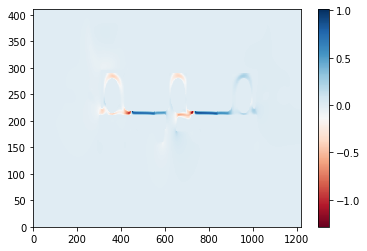

In [15]:
#%matplotlib nbagg
%matplotlib inline


import pandas as pd
import time
import struct
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import ArtistAnimation
import seaborn as sb
import glob

#■■バイナリ変換メソッド■■

def csvoutput_u(uf,vf,wf,xmax,ymax,zmax):
    #rbオプションは読み込みオンリー。書き込みたい場合には'wb'
    u=open(uf,'rb').read()
    #Structモジュールのunpack関数。第一引数はフォーマット。
    #この場合は倍精度(ダブルのd)8バイトずつ読み込む。//8とはデータ全体を8で割った商を表す。第二因数はバッファー(データ))
    ua=struct.unpack('d'*(len(u)//8),u)
    #u(流れ方向)
    ua_array=np.array([ua])
    #ua_array.transpose()
    ua_array=ua_array.reshape(ymax,xmax)
    
    return ua_array

def csvoutput_v(uf,vf,wf,xmax,ymax,zmax):
    #rbオプションは読み込みオンリー。書き込みたい場合には'wb'
    v=open(vf,'rb').read()
    #Structモジュールのunpack関数。第一引数はフォーマット。
    #この場合は倍精度(ダブルのd)8バイトずつ読み込む。//8とはデータ全体を8で割った商を表す。第二因数はバッファー(データ))
    va=struct.unpack('d'*(len(v)//8),v)
    #ｖ(高さ方向)
    va_array=np.array([va])
    #va_array.transpose()
    va_array=va_array.reshape(ymax,xmax)
    
    return va_array

def csvoutput_w(uf,vf,wf,xmax,ymax,zmax):
    #rbオプションは読み込みオンリー。書き込みたい場合には'wb'
    w=open(wf,'rb').read()
    #Structモジュールのunpack関数。第一引数はフォーマット。
    wa=struct.unpack('d'*(len(w)//8),w)
    #ｗ(幅方向)
    wa_array=np.array([wa])
    #wa_array.transpose()
    wa_array=wa_array.reshape(ymax,xmax)

    return wa_array

#■■info.txtからxmaxなどの情報を取得■■    
def infoReader(myPath):
    #print(myPath + '/info.txt')
    #with構文を使うことで、close処理を行わなくても済む。通常であれば

    inf = open(myPath,mode = 'r')
    text = inf.read()
    data=text.split()
    inf.close()
    
    return data


#■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■
#■■■■■■■■■■■■■メインメソッド■■■■■■■■■■■■■
#■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■

if __name__=='__main__':
    
    CFD_data = 'G3.5test'
    # 基板先頭位置(topEdge)を示すディレクトリパス、リスト
    dataPath= glob.glob('./' + CFD_data + '/*')
    #info.txt読み出しのためのファイルパスリスト
    infoPath = glob.glob('./' + CFD_data + '/*/info.txt')
    #info.txtから得る情報は、xmax,ymax,zmaxの格子情報だけなので、別にリストで得る必要はなし
    pathInfo = infoPath[0]

    #info.txtから必要な情報を読み出すinfoloader
    #-----------------------------------------------------------------------------------------------------
    #メッシュ数の情報をinfo.txtから読み出すため、各ディレクトリ内の最終ステップ名のフォルダパスをリスト
    #info.txtからxmax,ymax,zmaxを読み出すが、これら情報は先頭位置に依存しないので最初のディレクトリから１回だけ読み出す
    infoData = infoReader(pathInfo)
    times = float(infoData[5])
    xmax = int(infoData[7])
    ymax = int(infoData[8])
    zmax = int(infoData[9])
    
    
    print (times)
    #print(xmax,ymax,zmax)
    
    W = 0
    L = 1.22
    H = 0.4
    
    #節点間距離㎜　(xは搬送方向、yは高さ方向、zは幅方向)
    dz = W / zmax
    dx = L / xmax
    dy = H / ymax
    #---------------------------------------------------------------------------------------------------
    
    for i in range(len(dataPath)):
        #u,v,w各速度成分データファイルへのファイルパスを取得
        ufldPath = glob.glob('./' + CFD_data + '/*/ufld.raw')
        vfldPath = glob.glob('./' + CFD_data + '/*/vfld.raw')
        wfldPath = glob.glob('./' + CFD_data + '/*/wfld.raw')
    
        fa = csvoutput_u(ufldPath[i], vfldPath[i], wfldPath[i] , xmax , ymax , zmax )
        fav = csvoutput_v(ufldPath[i], vfldPath[i], wfldPath[i] , xmax , ymax , zmax )
        faw = csvoutput_w(ufldPath[i], vfldPath[i], wfldPath[i] , xmax , ymax , zmax )

        fasort = fa[::-1,::-1]
        favsort =fav[::-1,::-1]
        fawsort = faw[::-1,::-1]

        
        favelo = (fasort**2+favsort**2)**0.5
        
        #グラフの表示(ax1:搬送方向成分, ax2:基板直交成分)-------------------------------ｰｰｰｰｰｰｰｰ-ｰｰｰｰ--------------
        
        fig=plt.figure()
        
        #im1 = plt.pcolormesh(etchAmountWhole, interpolation='none',cmap='RdBu')
        im1 = plt.pcolormesh(fasort, cmap = 'RdBu')
        fig.colorbar(im1)
        plt.pause(0.1)
        
         #切り出したuva_arrayt_glassから任意の指定の小領域(タイル)毎の部分和を出力
            
        os.mkdir('./'+ str(CFD_data) + '_' + 'rslt')
        np.savetxt('./' + str(CFD_data) +'_' + 'rslt/' + str(CFD_data) + '_' + 'u.csv',fasort,delimiter = ',')
        np.savetxt('./' + str(CFD_data) +'_' + 'rslt/' + str(CFD_data) + '_' + 'w.csv',fawsort,delimiter = ',')
        np.savetxt('./' + str(CFD_data) +'_' + 'rslt/' + str(CFD_data) + '_' + 'v.csv',favsort,delimiter = ',')
        np.savetxt('./' + str(CFD_data) +'_' + 'rslt/' + str(CFD_data) + '_' + 'Velo.csv',favelo,delimiter = ',')